# Helical Quick Start Tutorial

Run this notebook on a colab notebook with a free GPU:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Quick-Start-Tutorial.ipynb)

This quick-start tutotial is meant to get you up and runninng quickly on Helical. If it is the first time you use helical, you can execute all cells sequentially (if you are already familiar with most concepts, you can jump to the most relevant section).

Please check out our other example notebooks on our [github](https://github.com/helicalAI/helical) in the `example` folder or in our [documentation](https://helical.readthedocs.io/) to explore actual applications of bio foundation models.

## Installation/Update of the Helical package
If you have never worked with helical, or if you want to have the latest version of Helical, be sure to run the cell below before getting started

In [1]:
%%hide output
try:
    import helical
except:
    !pip install git+https://github.com/helicalAI/helical.git |tail -n 1
    !pip install numpy==1.23.5
    import helical

UsageError: Cell magic `%%hide` not found.


## Installation of the data set used in our example notebooks
The data we will work with through out different examples is a subset of the human PBMC, comprising 54,760 training cells and 13,690 test cells, with 16,906 genes across 11 distinct cell types. We have provided an automatic download link below (it checks if the file already exsists and dowloads it if not).

You can also download it form the following link manually:
https://helicalpackage.blob.core.windows.net/helicalpackage/data/10k_pbmcs_proc.h5ad

In [2]:
import os
import requests

url = "https://helicalpackage.blob.core.windows.net/helicalpackage/data/10k_pbmcs_proc.h5ad"

# Extract the filename and download the file
filename = url.split("/")[-1]

# Check if the file already exists in the current directory
if os.path.exists(filename):
    print(f"{filename} already exist. Skipping downloads.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {filename} successfully.")
    else:
        print(f"Failed to download {filename}.")

Downloaded 10k_pbmcs_proc.h5ad successfully.


In [3]:
import anndata as ad

ann_data = ad.read_h5ad("10k_pbmcs_proc.h5ad")
ann_data

AnnData object with n_obs × n_vars = 11990 × 12000
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_types', 'hvg'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'

Unamiliar with anndata ? anndata is a Python package for handling annotated data matrices in memory and on disk, positioned between pandas and xarray. You can find thei docuemntation [here](https://anndata.readthedocs.io/).

## Select the model you want to work with
As of now, Helical allows you to work with the main RNA models. Over time new models trained on DNA, RNA and proteins will be added. The models are also outline in our [doc]().

To query our models, you can use run the cell below:

In [4]:
from helical import models
import pkgutil
for model in pkgutil.iter_modules(models.__path__):
    print("Model :",model.name)

Model : geneformer
Model : helical
Model : scgpt
Model : uce


## Import and download the model of your choice
We made it really easy for you here. The first time you want to work with a new model, by simply calling it, Helical will automatically download the model weights and all supporting files that you will require.

In the example below, we want to work with Geneformer:

In [6]:
from helical.models.geneformer.model import Geneformer, GeneformerConfig
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_config = GeneformerConfig(batch_size=10,device=device)
geneformer = Geneformer(configurer=model_config)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-05-06, 10:13:46.821 Downloader INFO File: '/Users/maximeallard/.cache/helical/models/geneformer/gene_median_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
2024-05-06, 10:13:46.821 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/geneformer/gene_median_dictionary.pkl'
2024-05-06, 10:13:46.822 Downloader INFO File: '/Users/maximeallard/.cache/helical/models/geneformer/human_gene_to_ensemble_id.pkl' exists already. File is not overwritten and nothing is downloaded.
2024-05-06, 10:13:46.822 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/geneformer/human_gene_to_ensemble_id.pkl'
2024-05-06, 10:13:46.822 Downloader INFO File: '/Users/maximeallard/.cache/helical/models/geneformer/token_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
2024-05-06, 10:13:46.823 Downloader INF

In [ ]:
#from helical.models.uce.model import UCE,UCEConfig

#model_config=UCEConfig(batch_size=10)
#uce = UCE(configurer=model_config)

## Process the data
Preprocessing your data can be complicated, especially when working with different models and benchmarking them. Our `process_data` function takes care of this for each model automatically.

In [7]:
dataset = geneformer.process_data(ann_data[:100], nproc=1, gene_names="gene_symbols", custom_attr_name_dict={"cell_type": "cell_type"})

Creating dataset.


/Users/maximeallard/helical/git/helical/helical/models/geneformer/model.py:92: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  data.var['ensembl_id'] = data.var['gene_symbols'].apply(lambda x: mappings.get(x,{"id":None})['id'])


Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

## Generate Embeddings
Let the magic happen!
Use the `get_embeddings()` function of each model to use to infere the embedding of each data point. These embeddings contain all the information encoded by the foundation model and can later be used in diverse use cases suach as cell type annotations.

In [8]:
embeddings = geneformer.get_embeddings(dataset)

print(embeddings.shape)

2024-05-06, 09:59:09.264 Geneformer-Model INFO Inference started


  0%|          | 0/10 [00:00<?, ?it/s]

(100, 512)


## Plot/visualize the embeddings
Finally, you can visualize these embeddings by using dimensionality reduction techniques such as UMAP.

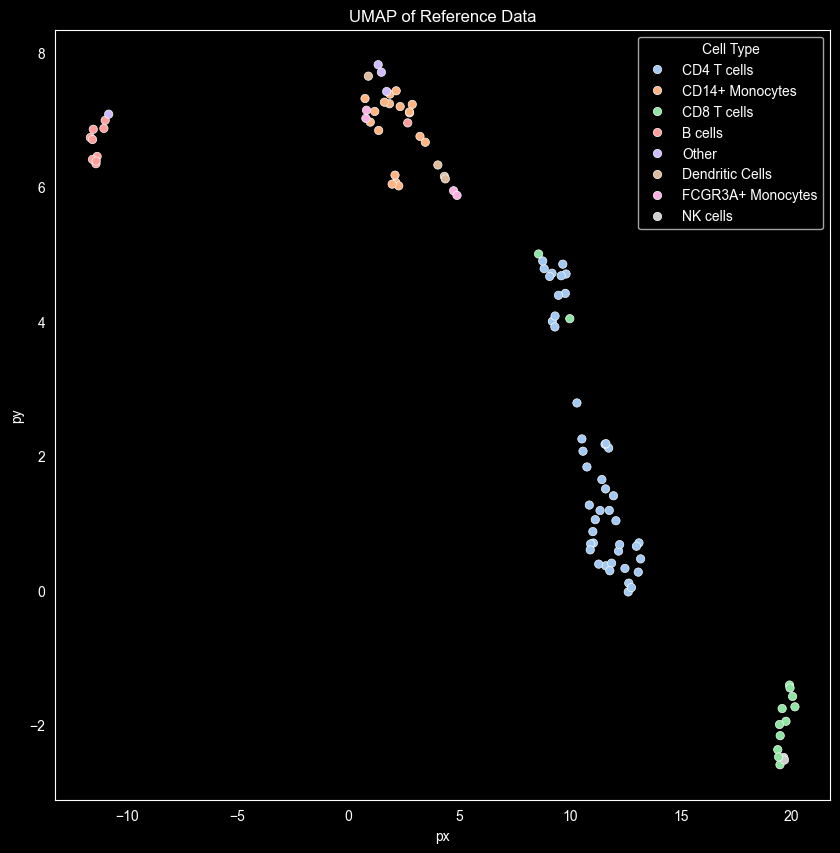

In [ ]:
import umap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=4)
mapper = reducer.fit(embeddings)

labels = dataset['cell_type']

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")
plt.title('UMAP of Reference Data')
plt.show()